# Imports and helper functions

To import packages and modules to Jupyter notebook, you need to setup a conda environment. Here we call it `gpst`.
```
conda create --name gpst
conda install -c conda-forge pypsa pandapower jupyterlab
pip install yaml vresutils==0.3.1
```
Upgrade to pandapower to develop branch
```
pip install git+git://github.com/e2nIEE/pandapower@develop
```
To  add the kernel for the jupyter notebook
```
pip install ipykernel
ipython kernel install --user --name=gpst
```

Open the jupyter lab notebook by typing `jupyter lab` in the terminal.


In [1]:
import os
import timeit
import pandas as pd

import numpy as np
import pandapower as pp
import pandapower.converter
        
import logging

# Show all pandas columns in jupyter
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [2]:
# Optional. Take local PyPSA-Dev installation to make adjustments
pypsa_path = os.getcwd()+"/PyPSA"  # require to have `PyPSA` cloned in ~/power-flow-exercise/example_pandapower/<PyPSA>`
import sys
sys.path.insert(0, f"{pypsa_path}")

In [3]:
import pypsa

In [4]:
def _sets_path_to_root(root_directory_name):
    """
    Search and sets path to the given root directory (root/path/file).

    Parameters
    ----------
    root_directory_name : str
        Name of the root directory.
    n : int
        Number of folders the function will check upwards/root directed.

    """
    import os

    repo_name = root_directory_name
    n = 8  # check max 8 levels above. Random default.
    n0 = n

    while n >= 0:
        n -= 1
        # if repo_name is current folder name, stop and set path
        if repo_name == os.path.basename(os.path.abspath(".")):
            repo_path = os.getcwd()  # os.getcwd() = current_path
            os.chdir(repo_path)  # change dir_path to repo_path
            print("This is the repository path: ", repo_path)
            print("Had to go %d folder(s) up." % (n0 - 1 - n))
            break
        # if repo_name NOT current folder name for 5 levels then stop
        if n == 0:
            print("Cant find the repo path.")
        # if repo_name NOT current folder name, go one dir higher
        else:
            upper_path = os.path.dirname(
                os.path.abspath("."))  # name of upper folder
            os.chdir(upper_path)

In [5]:
_sets_path_to_root("power-flow-exercise")  # name of the git # n.generators_t.p_set = clone folder

This is the repository path:  /home/max/OneDrive/PHD-Flexibility/07_pypsa-africa/0github/power-flow-exercise
Had to go 1 folder(s) up.


In [6]:
# Set logger
logging.basicConfig(filename=os.path.join("example_pandapower", "log.out"),
                    filemode='w',
                    format='%(asctime)s %(name)s %(levelname)s %(message)s',
                    datefmt='%H:%M:%S',
                    level=logging.INFO)

logger = logging.getLogger(__name__)

# Pandapower import of Matpower

In [7]:
net = pp.converter.from_mpc(os.path.join("reference-matpower", "RTS_GMLC.mat"))

# Comparing Pandapower to solved Matpower network

In [8]:
def compare_to_matpower(net):
    """
    Compares pandapower network to matpower network.
    """
    bus_results = pd.read_csv(os.path.join("reference-matpower", "results", "bus.csv"), index_col=0)
    branch_results = pd.read_csv(os.path.join("reference-matpower", "results", "flow.csv"), index_col=0)

    # compare bus results
    # merged_results = pd.merge(bus_results, net.res_bus, how='inner', left_index=True, right_on=net.bus.id)
    merged_results = pd.merge(bus_results, net.res_bus, how='inner', left_index=True, right_on=net.bus.name)
    merged_results['diff_vm_pu'] = merged_results.v_mag - merged_results.vm_pu
    merged_results['diff_va_degree'] = merged_results.v_ang - merged_results.va_degree
    logger.info(f"\n{merged_results[['diff_vm_pu', 'diff_va_degree']].describe()}")

    # compare branch results
    merged_results_line = pd.merge(branch_results, net.res_line, how='inner', left_index=True, right_index=True)
    merged_results_line['diff_from_p_mw'] = merged_results_line.p_from_mw - merged_results_line.from_bus_inj_p
    merged_results_line['diff_to_p_mw'] = merged_results_line.p_to_mw - merged_results_line.to_bus_inj_p
    merged_results_line['diff_from_q_mvar'] = merged_results_line.q_from_mvar - merged_results_line.from_bus_inj_q
    merged_results_line['diff_to_q_mvar'] = merged_results_line.q_to_mvar - merged_results_line.to_bus_inj_q
    merged_results_line['diff_loss_p'] = merged_results_line.pl_mw - merged_results_line.loss_p
    cols = ['diff_from_p_mw', 'diff_to_p_mw', 'diff_from_q_mvar', 'diff_to_q_mvar', 'diff_loss_p']
    logger.info(f"\n{merged_results_line[cols].describe()}")

In [9]:
net.sgen.drop(net.sgen[~net.sgen.in_service].index, inplace=True)  # TODO: check if this is correct (dropping not in_service elements from net.sgen
pp.runpp(net)
compare_to_matpower(net)  # Info: Will be saved in logger 'log.out'

# Prepare Pandapower network

In [10]:
def make_name_to_index(net):
    """
    Makes name as index.
    
    PyPSA requires a unique name as index.
    """
    for elm in net.keys():
        if elm.startswith("_") or not isinstance(net[elm], pd.DataFrame) or len(net[elm]) == 0:
            continue
        # let's keep the bus names from mpc
        if elm == 'bus':
            continue
        net[elm]['name'] = [f"{elm}_{i}" for i in net[elm].index.values]
        # checking because in_service not supported by pypsa
        if 'in_service' in net[elm].columns:
            assert np.alltrue(net[elm]['in_service']), f"not in_service elements found in {elm}"
        # checking because switches are not supported by pypsa
        if elm == 'switch':
            assert np.alltrue(net[elm]['closed']), "open switches found"
        if elm == "trafo3w" and len(net[elm]) > 0:
            logger.warning("found trafo3w in net (not supported by pypsa converter!!!)")
        if elm == "shunt" and len(net[elm]) > 0:
            logger.warning("found shunt in net (not supported by pypsa converter!!!)")

In [11]:
make_name_to_index(net)

# PyPSA import of Pandapower network

In [12]:
# Build empty PyPSA network
network = pypsa.Network()
# Import pandapower
network.import_from_pandapower_net(net, True, use_pandapower_index=True)

### Checks if import is correct

In [17]:
# now let's check some basic infos
assert len(network.buses) == len(net.bus)
assert len(network.generators) == (len(net.gen) + len(net.sgen) + len(net.ext_grid))
assert len(network.loads) == len(net.load)
assert len(network.transformers) == len(net.trafo)
assert len(network.shunt_impedances) == len(net.shunt)
# todo: shunt impedances are not supported
# todo: trafo tap positions are not supported
# todo: trafo3w are not supported

# Inspect PyPSA network before solving

In [18]:
n = network

In [19]:
n.snapshots

Index(['now'], dtype='object', name='snapshot')

In [20]:
n.global_constraints

attribute,type,investment_period,carrier_attribute,sense,constant,mu
GlobalConstraint,,,,,,


In [21]:
n.buses

,v_nom,v_mag_pu_set,type,x,y,carrier,unit,v_mag_pu_min,v_mag_pu_max,control,sub_network
Bus,,,,,,,,,,,
0,138.0,1.0468,,0.0,0.0,AC,None,0.0,inf,PQ,
1,138.0,1.0467,,0.0,0.0,AC,None,0.0,inf,PQ,
2,138.0,1.0000,,0.0,0.0,AC,None,0.0,inf,PQ,
3,138.0,1.0000,,0.0,0.0,AC,None,0.0,inf,PQ,
4,138.0,1.0000,,0.0,0.0,AC,None,0.0,inf,PQ,
5,138.0,1.0000,,0.0,0.0,AC,None,0.0,inf,PQ,
6,138.0,1.0500,,0.0,0.0,AC,None,0.0,inf,PQ,
7,138.0,1.0000,,0.0,0.0,AC,None,0.0,inf,PQ,
8,138.0,1.0000,,0.0,0.0,AC,None,0.0,inf,PQ,


In [22]:
n.generators

,p_set,q_set,bus,control,type,p_nom,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,sign,carrier,marginal_cost,build_year,lifetime,capital_cost,efficiency,committable,start_up_cost,shut_down_cost,min_up_time,min_down_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt
Generator,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,8.00,0.000000,0,PV,,0.0,False,0.0,inf,0.0,1.0,1.0,,0.0,0,inf,0.0,1.0,False,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
1,8.00,0.000000,1,PV,,0.0,False,0.0,inf,0.0,1.0,1.0,,0.0,0,inf,0.0,1.0,False,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
2,355.00,0.000000,6,PV,,0.0,False,0.0,inf,0.0,1.0,1.0,,0.0,0,inf,0.0,1.0,False,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
3,5.00,0.000000,14,PV,,0.0,False,0.0,inf,0.0,1.0,1.0,,0.0,0,inf,0.0,1.0,False,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
4,155.00,0.000000,15,PV,,0.0,False,0.0,inf,0.0,1.0,1.0,,0.0,0,inf,0.0,1.0,False,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
5,355.00,0.000000,17,PV,,0.0,False,0.0,inf,0.0,1.0,1.0,,0.0,0,inf,0.0,1.0,False,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
6,155.00,0.000000,22,PV,,0.0,False,0.0,inf,0.0,1.0,1.0,,0.0,0,inf,0.0,1.0,False,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
7,8.00,0.000000,24,PV,,0.0,False,0.0,inf,0.0,1.0,1.0,,0.0,0,inf,0.0,1.0,False,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0
8,8.00,0.000000,25,PV,,0.0,False,0.0,inf,0.0,1.0,1.0,,0.0,0,inf,0.0,1.0,False,0.0,0.0,0,0,1,0,NaN,NaN,1.0,1.0,0.0


In [23]:
n.loads_t

{'p_set': Empty DataFrame
 Columns: []
 Index: [now],
 'q_set': Empty DataFrame
 Columns: []
 Index: [now],
 'p': Empty DataFrame
 Columns: []
 Index: [now],
 'q': Empty DataFrame
 Columns: []
 Index: [now]}

In [24]:
n.loads

,p_set,q_set,bus,carrier,type,sign
Load,,,,,,
0,108.0,22.0,0,,,-1.0
1,97.0,20.0,1,,,-1.0
2,180.0,37.0,2,,,-1.0
3,74.0,15.0,3,,,-1.0
4,71.0,14.0,4,,,-1.0
5,136.0,28.0,5,,,-1.0
6,125.0,25.0,6,,,-1.0
7,171.0,35.0,7,,,-1.0
8,175.0,36.0,8,,,-1.0


In [25]:
n.lines

,r,x,b,s_nom,bus0,bus1,length,num_parallel,type,g,s_nom_extendable,s_nom_min,s_nom_max,s_max_pu,capital_cost,build_year,lifetime,carrier,terrain_factor,v_ang_min,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu,x_pu_eff,r_pu_eff,s_nom_opt
Line,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.57132,2.66616,0.002421,101.036297,0,1,1.0,1.0,,0.0,False,0.0,inf,1.0,0.0,0,inf,,1.0,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10.47420,40.18284,0.000299,101.036297,0,2,1.0,1.0,,0.0,False,0.0,inf,1.0,0.0,0,inf,,1.0,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.18968,16.18740,0.000121,101.036297,0,4,1.0,1.0,,0.0,False,0.0,inf,1.0,0.0,0,inf,,1.0,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.28452,24.18588,0.000179,101.036297,1,3,1.0,1.0,,0.0,False,0.0,inf,1.0,0.0,0,inf,,1.0,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9.52200,36.56448,0.000273,101.036297,1,5,1.0,1.0,,0.0,False,0.0,inf,1.0,0.0,0,inf,,1.0,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,5.90364,22.66236,0.000168,101.036297,2,8,1.0,1.0,,0.0,False,0.0,inf,1.0,0.0,0,inf,,1.0,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,5.14188,19.80576,0.000147,101.036297,3,8,1.0,1.0,,0.0,False,0.0,inf,1.0,0.0,0,inf,,1.0,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,4.38012,16.75872,0.000126,101.036297,4,9,1.0,1.0,,0.0,False,0.0,inf,1.0,0.0,0,inf,,1.0,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,2.66616,11.61684,0.012912,101.036297,5,9,1.0,1.0,,0.0,False,0.0,inf,1.0,0.0,0,inf,,1.0,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
n.transformers

,phase_shift,s_nom,bus0,bus1,r,x,g,b,tap_position,type,model,s_nom_extendable,s_nom_min,s_nom_max,s_max_pu,capital_cost,num_parallel,tap_ratio,tap_side,build_year,lifetime,v_ang_min,v_ang_max,sub_network,x_pu,r_pu,g_pu,b_pu,x_pu_eff,r_pu_eff,s_nom_opt
Transformer,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.4,23,2,0.00002,0.00084,0.0,0.0,1,,t,False,0.0,inf,1.0,0.0,1.0,1.0,0,0,inf,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.4,10,8,0.00002,0.00084,0.0,0.0,1,,t,False,0.0,inf,1.0,0.0,1.0,1.0,0,0,inf,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.4,11,8,0.00002,0.00084,0.0,0.0,1,,t,False,0.0,inf,1.0,0.0,1.0,1.0,0,0,inf,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.4,10,9,0.00002,0.00084,0.0,0.0,1,,t,False,0.0,inf,1.0,0.0,1.0,1.0,0,0,inf,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.4,11,9,0.00002,0.00084,0.0,0.0,1,,t,False,0.0,inf,1.0,0.0,1.0,1.0,0,0,inf,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.4,47,26,0.00002,0.00084,0.0,0.0,1,,t,False,0.0,inf,1.0,0.0,1.0,1.0,0,0,inf,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.4,34,32,0.00002,0.00084,0.0,0.0,1,,t,False,0.0,inf,1.0,0.0,1.0,1.0,0,0,inf,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.4,35,32,0.00002,0.00084,0.0,0.0,1,,t,False,0.0,inf,1.0,0.0,1.0,1.0,0,0,inf,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.4,34,33,0.00002,0.00084,0.0,0.0,1,,t,False,0.0,inf,1.0,0.0,1.0,1.0,0,0,inf,-inf,inf,,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
n.links

attribute,bus0,bus1,type,carrier,efficiency,build_year,lifetime,p_nom,p_nom_extendable,p_nom_min,p_nom_max,p_set,p_min_pu,p_max_pu,capital_cost,marginal_cost,length,terrain_factor,p_nom_opt
Link,,,,,,,,,,,,,,,,,,,


In [28]:
n.stores

attribute,bus,type,carrier,e_nom,e_nom_extendable,e_nom_min,e_nom_max,e_min_pu,e_max_pu,e_initial,e_initial_per_period,e_cyclic,e_cyclic_per_period,p_set,q_set,sign,marginal_cost,capital_cost,standing_loss,build_year,lifetime,e_nom_opt
Store,,,,,,,,,,,,,,,,,,,,,,


In [29]:
n.storage_units

attribute,bus,control,type,p_nom,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,p_set,q_set,sign,carrier,marginal_cost,capital_cost,build_year,lifetime,state_of_charge_initial,state_of_charge_initial_per_period,state_of_charge_set,cyclic_state_of_charge,cyclic_state_of_charge_per_period,max_hours,efficiency_store,efficiency_dispatch,standing_loss,inflow,p_nom_opt
StorageUnit,,,,,,,,,,,,,,,,,,,,,,,,,,,,


In [30]:
n.shunt_impedances

,bus,g,b,sign,g_pu,b_pu
ShuntImpedance,,,,,,
0,5,0.0,0.005251,-1.0,0.0,0.0
1,29,0.0,0.005251,-1.0,0.0,0.0
2,53,0.0,0.005251,-1.0,0.0,0.0


In [31]:
n.carriers

attribute,co2_emissions,color,nice_name,max_growth
Carrier,,,,


# Adjustment of pandapower network

In [ ]:
n.generators.loc[:,"p_set"] = abs(n.generators.loc[:,"p_set"])
n.generators.loc[:,"q_set"] = -(n.generators.loc[:,"q_set"])

In [ ]:
n.loads.loc[:,["p_set", "q_set"]] = (n.loads.loc[:,["p_set", "q_set"]])*0.5

In [ ]:
n.loads.loc[:,["q_set"]] = (n.loads.loc[:,["q_set"]])*0.1

In [ ]:
n.buses.v_mag_pu_set = 1.

In [ ]:
n.lines.loc["104","r"] = 1.

In [ ]:
n.transformers.r = 2e-5
n.transformers.x = 8.4e-4
n.transformers.tap_position = 0
n.transformers.r = 2e-5
n.transformers.x = 8.4e-4
n.transformers

In [ ]:
n.buses_t.v_mag_pu.T.plot()

In [ ]:
n.sub_networks

In [ ]:
pandanet = n.copy()

In [ ]:
pandanet.buses

In [ ]:
n.mremove("Load", pandanet.loads.index.values)

In [ ]:
n.madd("Load", pandanet.loads.index.values,

       bus=pandanet.loads.bus.values,

       p_set=pandanet.loads.p_set.values*0.5)

In [ ]:
n.loads_t.p_set = n.loads_t.p

In [ ]:
n.generators_t.p_set = n.generators_t.p

In [ ]:
n.loads

# Solve network

In [ ]:
n.loads.p_set.sum()
n.loads.q_set.sum()

n.transformers_t.p0.sum().plot()

In [32]:
#n.lopf()
#n.pf(use_seed=True, distribute_slack=True)
#n.pf(x_tol=1e-6,)
n.pf()
# n.lpf()

{'n_iter': SubNetwork  0
 snapshot     
 now         5,
 'error': SubNetwork             0
 snapshot                
 now         2.386034e-10,
 'converged': SubNetwork     0
 snapshot        
 now         True}

# Compare outputs of pandapower vs pypsa

<AxesSubplot:>

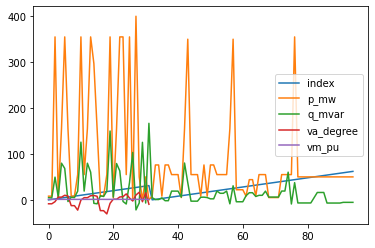

In [61]:
(net.res_gen.append(net.res_sgen)).reset_index().plot()

<AxesSubplot:xlabel='Generator'>

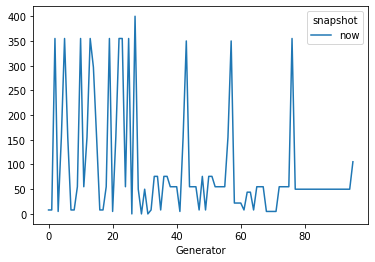

In [48]:
n.generators_t.p.T.plot()


<AxesSubplot:>

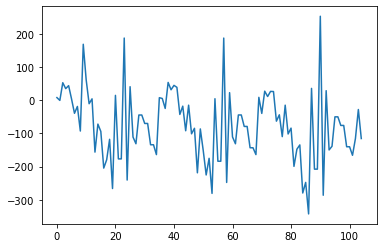

In [65]:
net.res_line.p_from_mw.plot()

<AxesSubplot:>

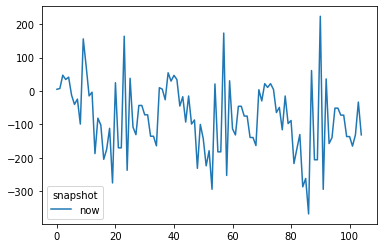

In [69]:
n.lines_t.p0.T.plot()

In [ ]:
ne

# Planning Exercise Test

### Load cost.csv

In [ ]:
import yaml
from vresutils.costdata import annuity

In [ ]:
def load_costs(Nyears=1., tech_costs=None, config=None, elec_config=None):
    if tech_costs is None:
        tech_costs = os.getcwd()+"/example-pypsa/costs.csv"

    if config is None:
        ### Loads raw config.yaml
        path = os.getcwd()+"/example-pypsa/config.yaml"
        with open(path, "r") as stream:
            try:
                config = yaml.safe_load(stream)
            except yaml.YAMLError as exc:
                print(exc)
        config = config['costs']

    # set all asset costs and other parameters
    costs = pd.read_csv(tech_costs, index_col=list(range(3))).sort_index()

    # correct units to MW and EUR
    costs.loc[costs.unit.str.contains("/kW"),"value"] *= 1e3
    costs.loc[costs.unit.str.contains("USD"),"value"] *= config['USD2013_to_EUR2013']

    idx = pd.IndexSlice
    costs = (costs.loc[idx[:,config['year'],:], "value"]
             .unstack(level=2).groupby("technology").sum(min_count=1))

    costs = costs.fillna({"CO2 intensity" : 0,
                          "FOM" : 0,
                          "VOM" : 0,
                          "discount rate" : config['discountrate'],
                          "efficiency" : 1,
                          "fuel" : 0,
                          "investment" : 0,
                          "lifetime" : 25})

    costs["capital_cost"] = ((annuity(costs["lifetime"], costs["discount rate"]) +
                             costs["FOM"]/100.) *
                             costs["investment"] * Nyears)

    costs.at['OCGT', 'fuel'] = costs.at['gas', 'fuel']
    costs.at['CCGT', 'fuel'] = costs.at['gas', 'fuel']

    costs['marginal_cost'] = costs['VOM'] + costs['fuel'] / costs['efficiency']

    costs = costs.rename(columns={"CO2 intensity": "co2_emissions"})

    costs.at['OCGT', 'co2_emissions'] = costs.at['gas', 'co2_emissions']
    costs.at['CCGT', 'co2_emissions'] = costs.at['gas', 'co2_emissions']

    costs.at['solar', 'capital_cost'] = 0.5*(costs.at['solar-rooftop', 'capital_cost'] +
                                             costs.at['solar-utility', 'capital_cost'])

    return costs

In [ ]:
def add_nice_carrier_names(n, config=None):
    if config is None:
        path = os.getcwd()+"/example-pypsa/config.yaml"
        with open(path, "r") as stream:
            try:
                config = yaml.safe_load(stream)
            except yaml.YAMLError as exc:
                print(exc)
        config = config

    carrier_i = n.carriers.index
    nice_names = (pd.Series(config['plotting']['nice_names'])
                  .reindex(carrier_i).fillna(carrier_i.to_series().str.title()))
    n.carriers['nice_name'] = nice_names
    colors = pd.Series(config['plotting']['tech_colors']).reindex(carrier_i)
    if colors.isna().any():
        missing_i = list(colors.index[colors.isna()])
        logger.warning(f'tech_colors for carriers {missing_i} not defined '
                       'in config.')
    n.carriers['color'] = colors

In [ ]:
costs = load_costs()

In [ ]:
costs

In [ ]:
add_nice_carrier_names(n)

In [ ]:
n.generators.loc[:,"carrier"] = "OCGT"
n.generators.loc[:,"capital_costs"] = costs.loc["OCGT", "capital_cost"]
n.generators.loc[:,"marginal_costs"] = costs.loc["OCGT", "marginal_cost"]
n.generators.loc[:,"lifetime"] = costs.loc["OCGT", "lifetime"]
n.generators.loc[:,"p_nom_extanable"] = "True"


n.lines.loc[:,'capital_cost'] = (n.lines['length'] * 1 * costs.at['HVAC overhead', 'capital_cost'])
n.lines.loc[:,"s_nom_extanable"] = "True"


n.transformers.loc[:,"s_nom_extanable"] = "True"


n.loads_t["p"] = n.loads_t["p"] * 5
n.loads["p_set"] = n.loads["p_set"] * 5

# Solve network

In [ ]:
from pypsa.linopf import (get_var, define_constraints, linexpr, join_exprs,
                          network_lopf, ilopf)

In [ ]:
### Loads raw config.yaml
path = os.getcwd()+"/example-pypsa/config.yaml"
with open(path, "r") as stream:
    try:
        config = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)
config = config

In [ ]:
def fix_bus_production(n, snapshots):
    total_demand = n.loads_t.p.sum().sum() 
    prod_per_bus = linexpr((1, get_var(n, 'Generator', 'p'))).groupby(n.generators.bus, axis=1).apply(join_exprs)
    define_constraints(n, prod_per_bus, '>=', total_demand/5, 'Bus', 'production_share')

def extra_functionality(n, snapshots):
    fix_bus_production(n, snapshots)

In [ ]:
def solve_network(n, config, opts='', **kwargs):
    solver_options = config['solving']['solver'].copy()
    solver_name = solver_options.pop('name')
    cf_solving = config['solving']['options']
    track_iterations = cf_solving.get('track_iterations', False)
    min_iterations = cf_solving.get('min_iterations', 4)
    max_iterations = cf_solving.get('max_iterations', 6)

    # add to network for extra_functionality
    n.config = config
    n.opts = opts

    if cf_solving.get('skip_iterations', False):
        network_lopf(n, solver_name=solver_name, solver_options=solver_options,
                     extra_functionality=extra_functionality, **kwargs)
    else:
        ilopf(n, solver_name=solver_name, solver_options=solver_options,
              track_iterations=track_iterations,
              min_iterations=min_iterations,
              max_iterations=max_iterations,
              extra_functionality=extra_functionality, **kwargs)
    return n


In [ ]:
from pathlib import Path

tmpdir = config['solving'].get('tmpdir')
if tmpdir is not None:
        Path(tmpdir).mkdir(parents=True, exist_ok=True)

n = solve_network(n, config=config,
                          solver_dir=tmpdir,)